[Info] Output directory: /content/mixing
[Info] dx=0.104167 m, dt=1e+07 s ≈ 0.317 yr; A0=4.000e-09 m/s


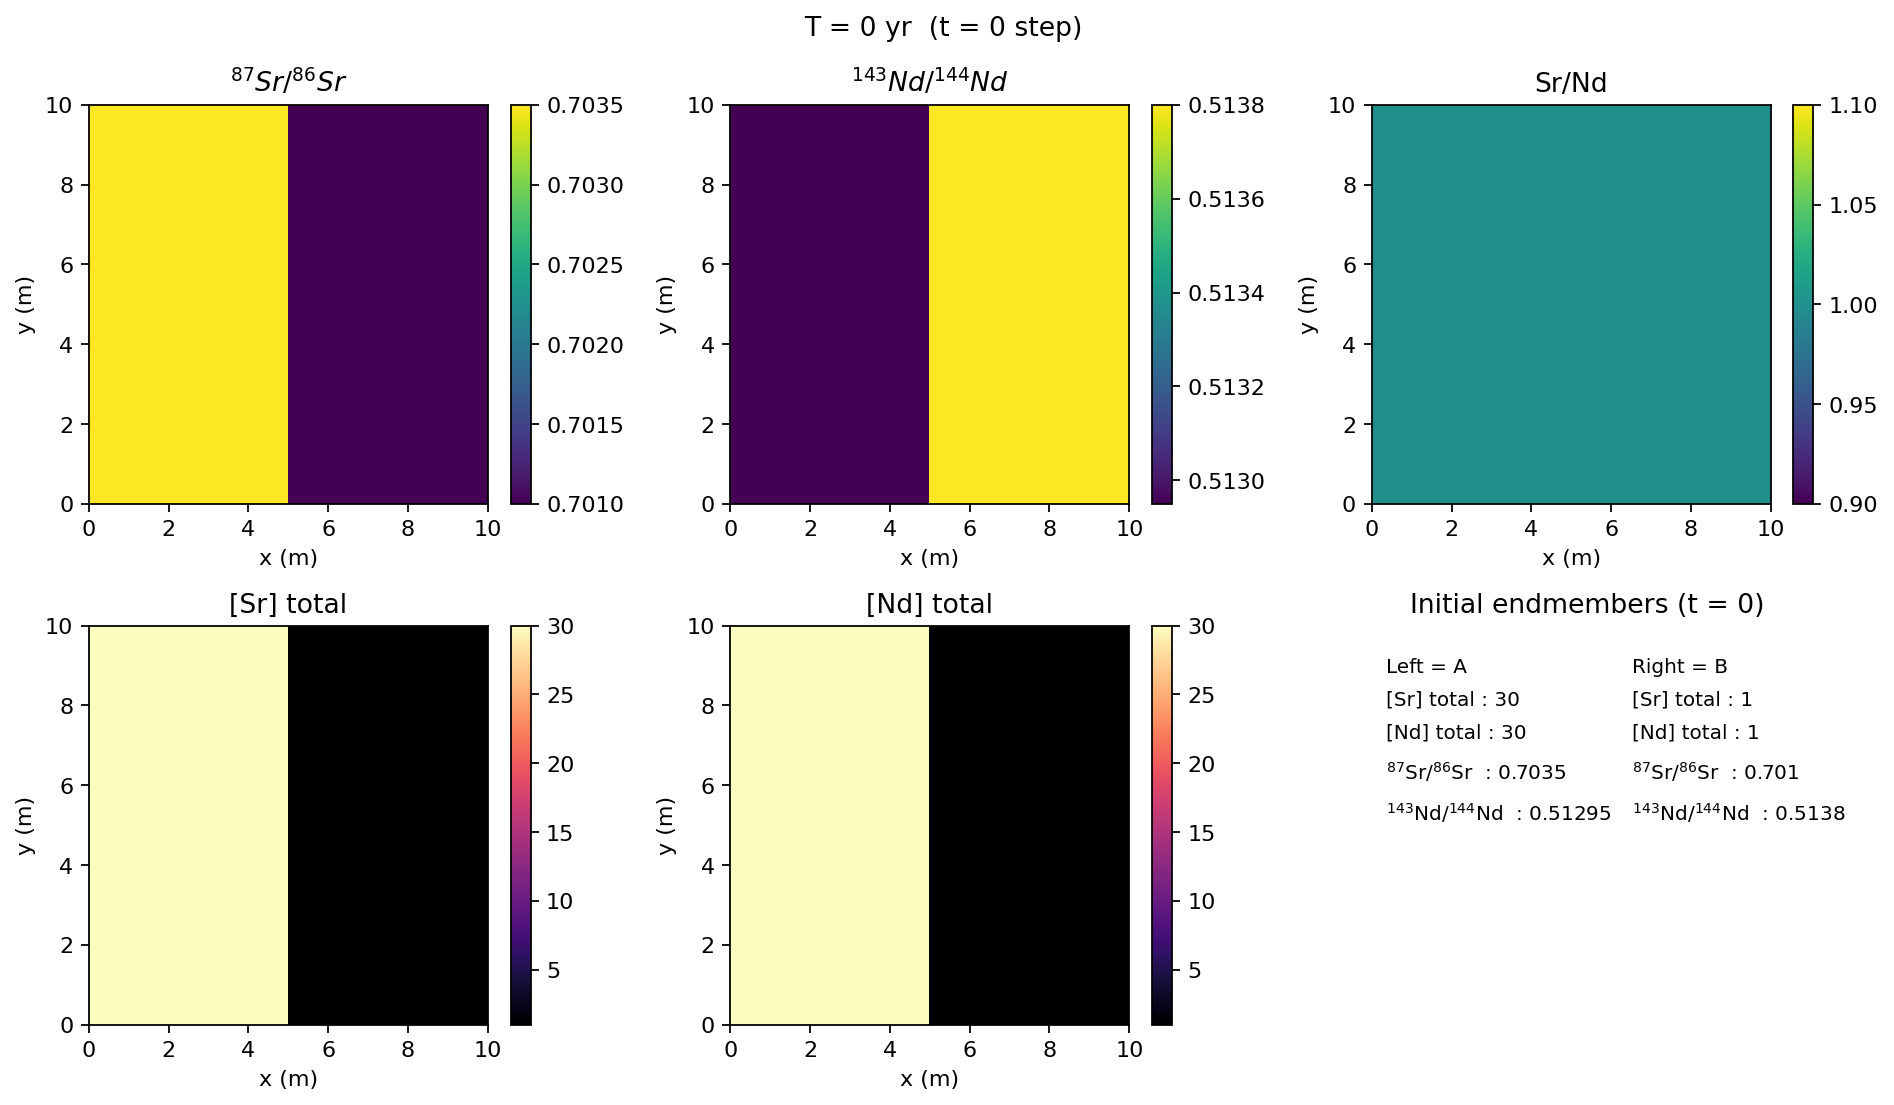

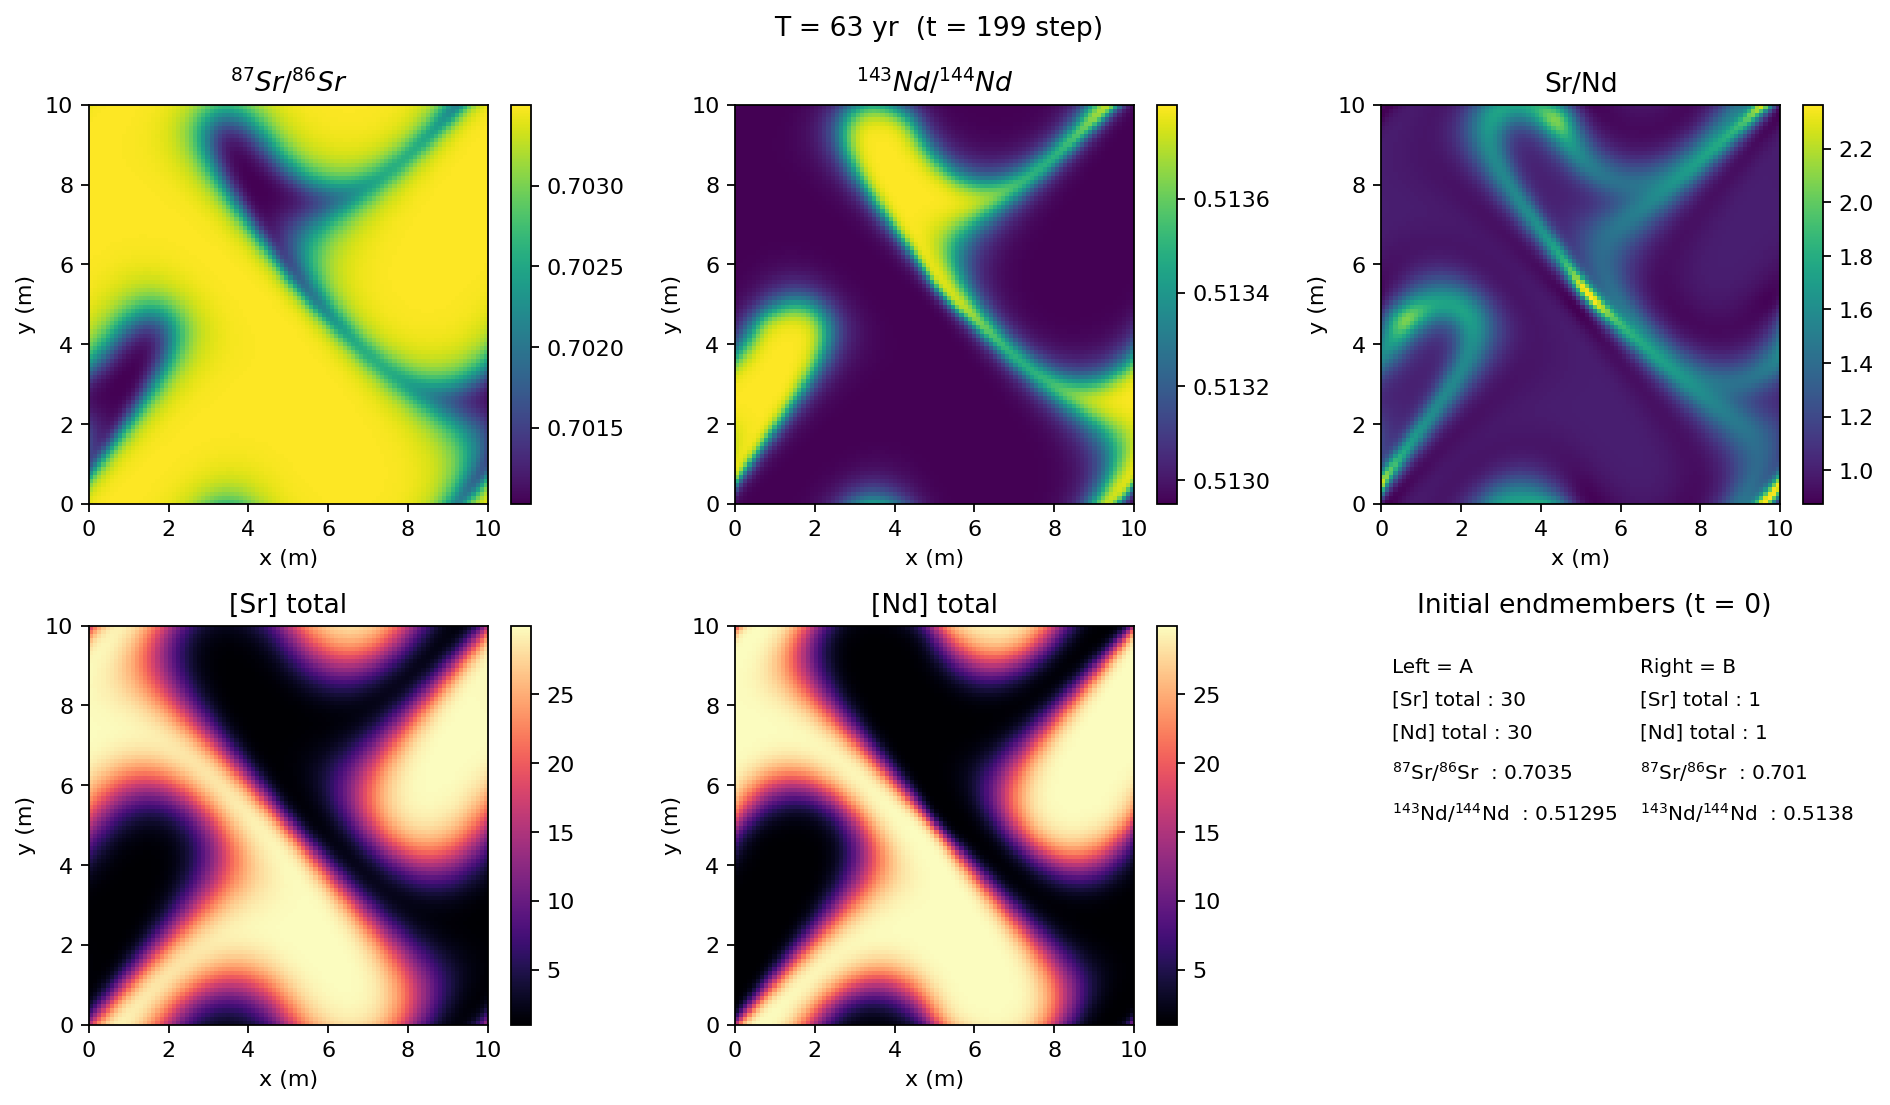

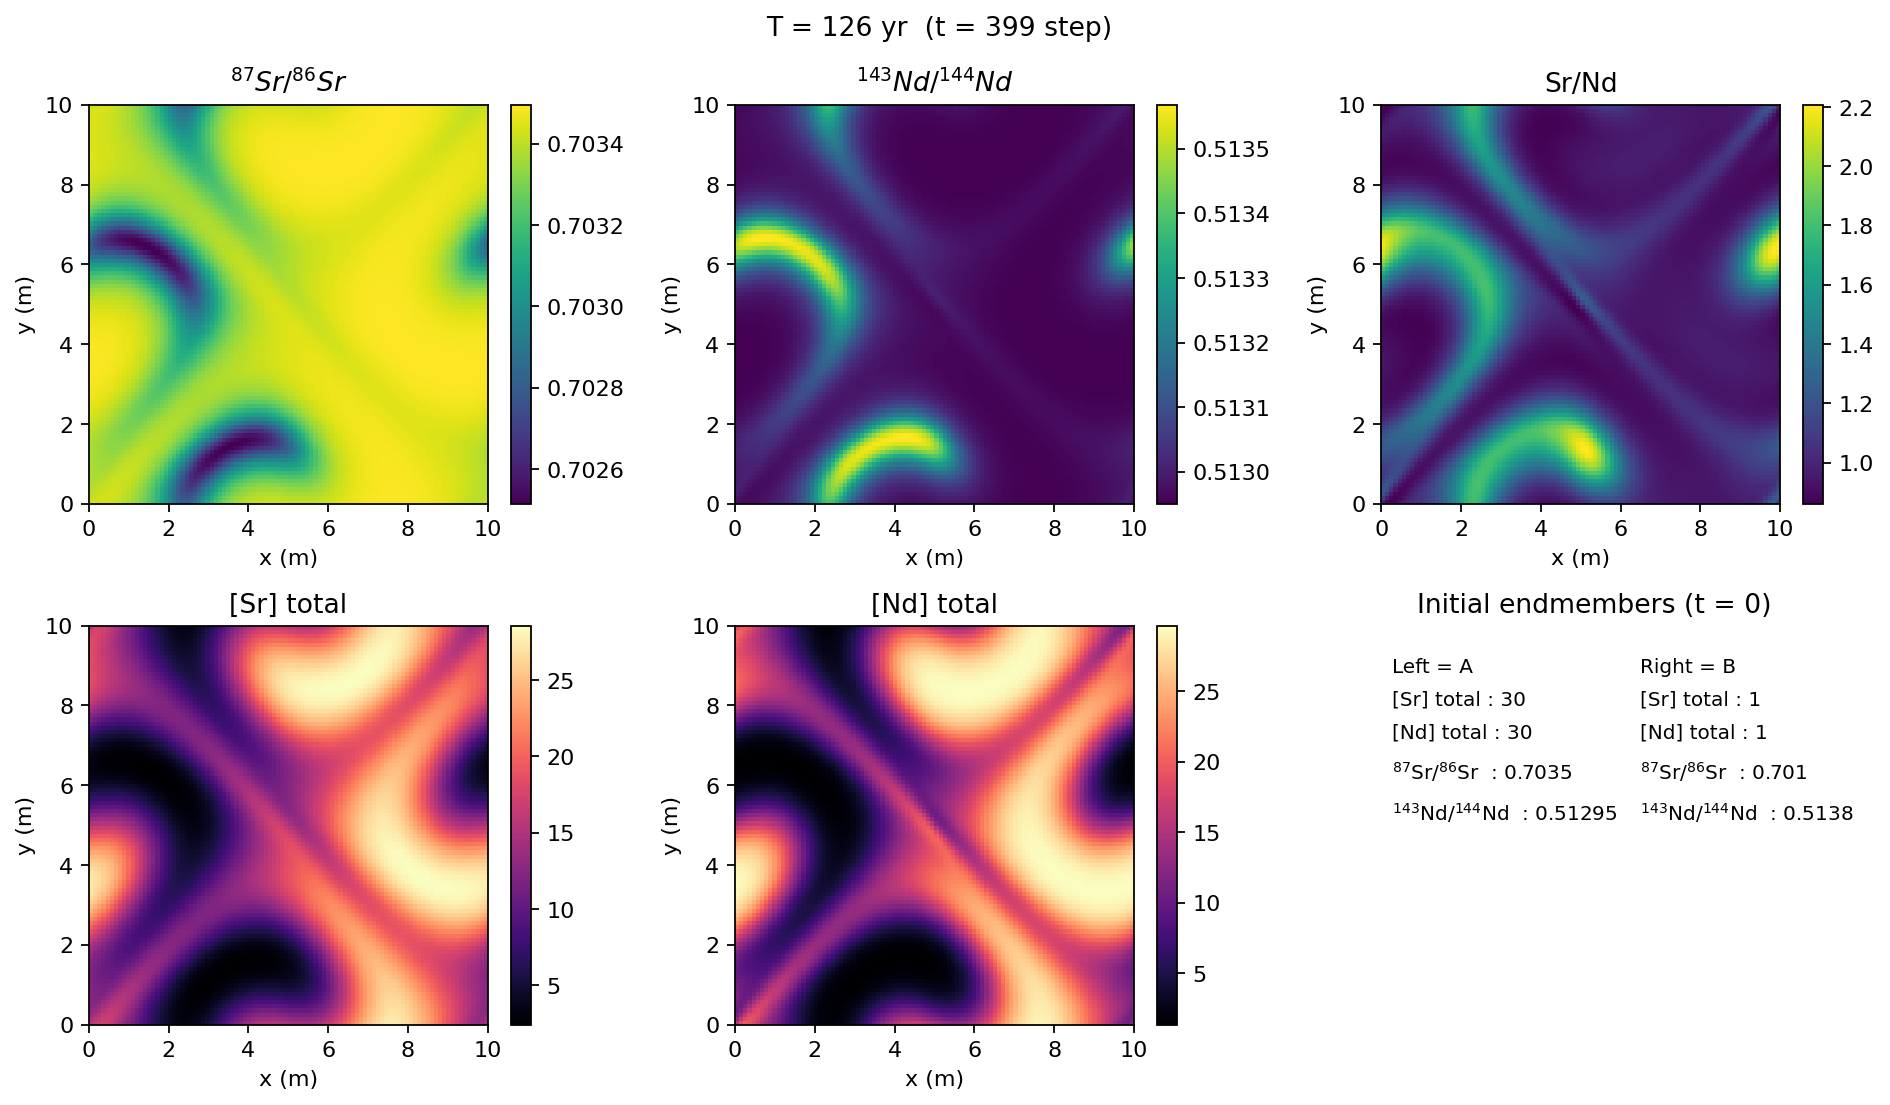

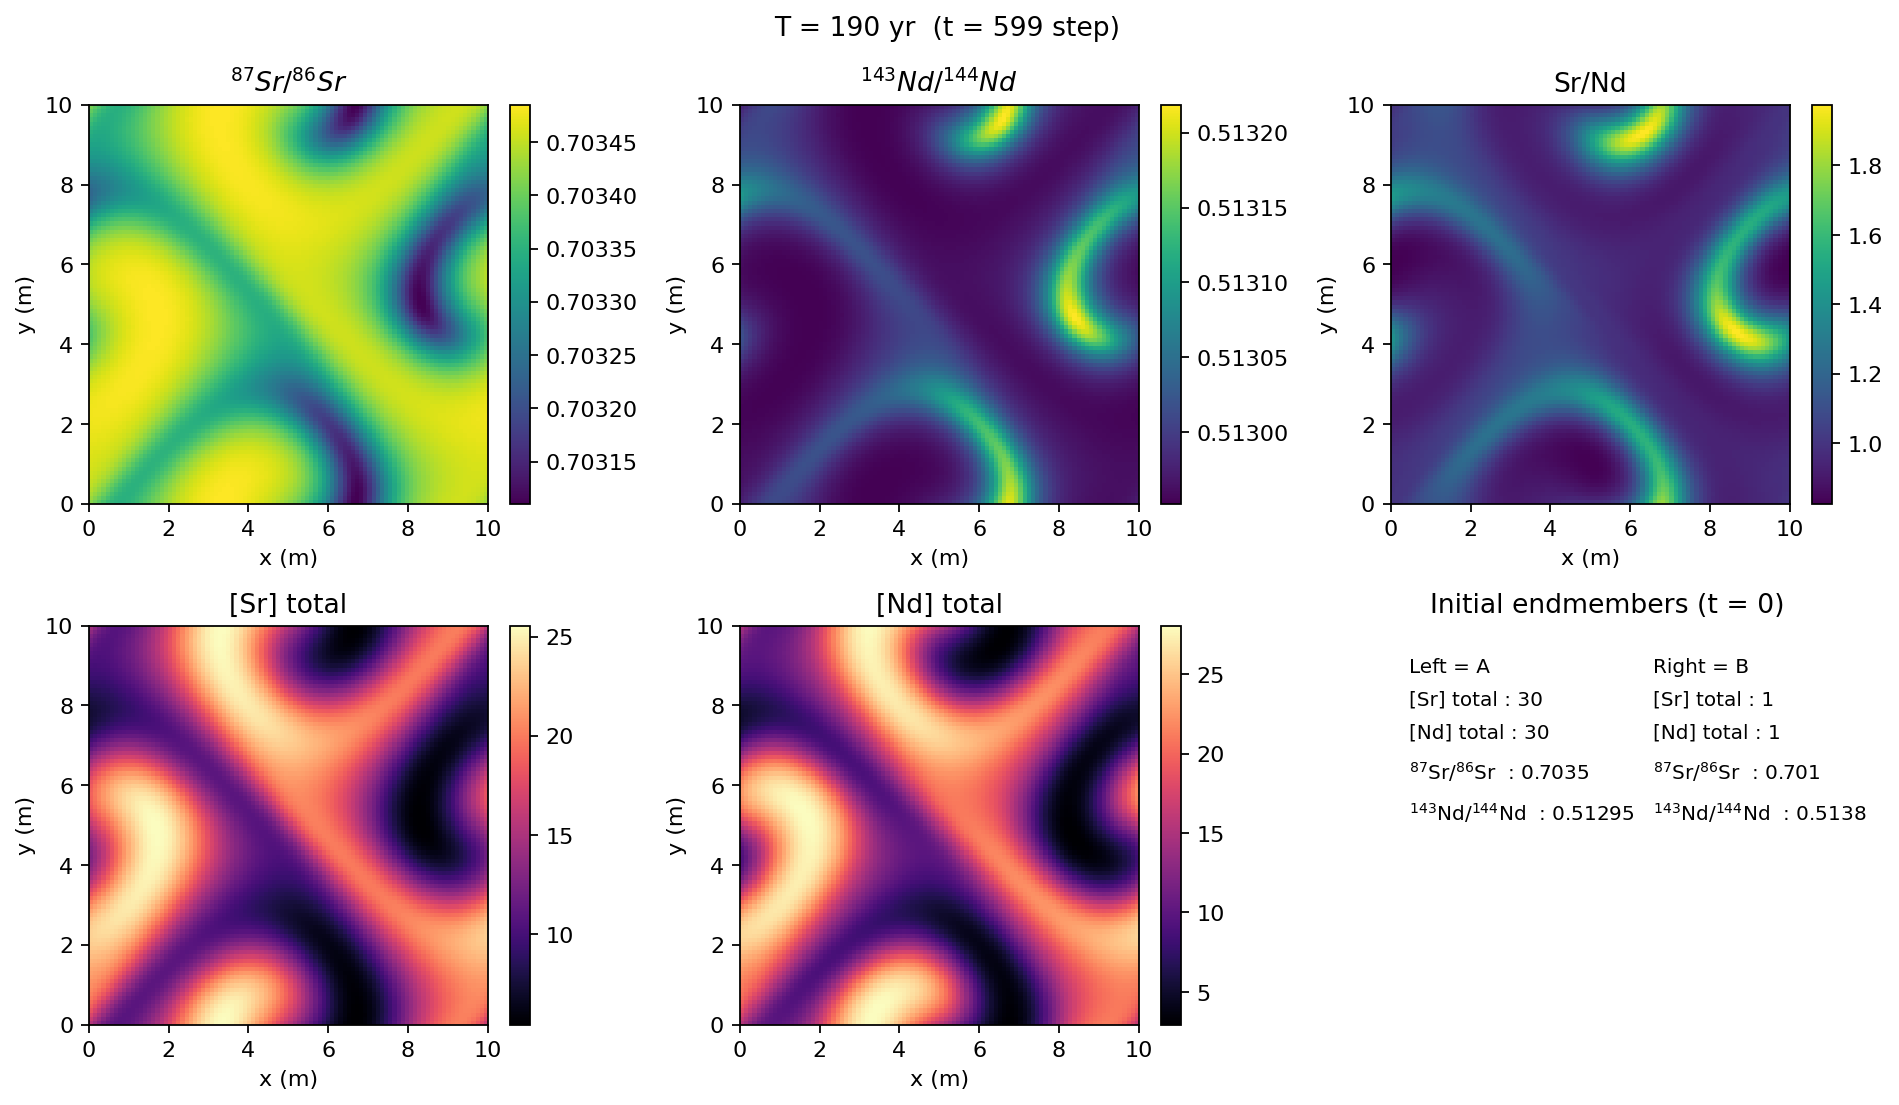

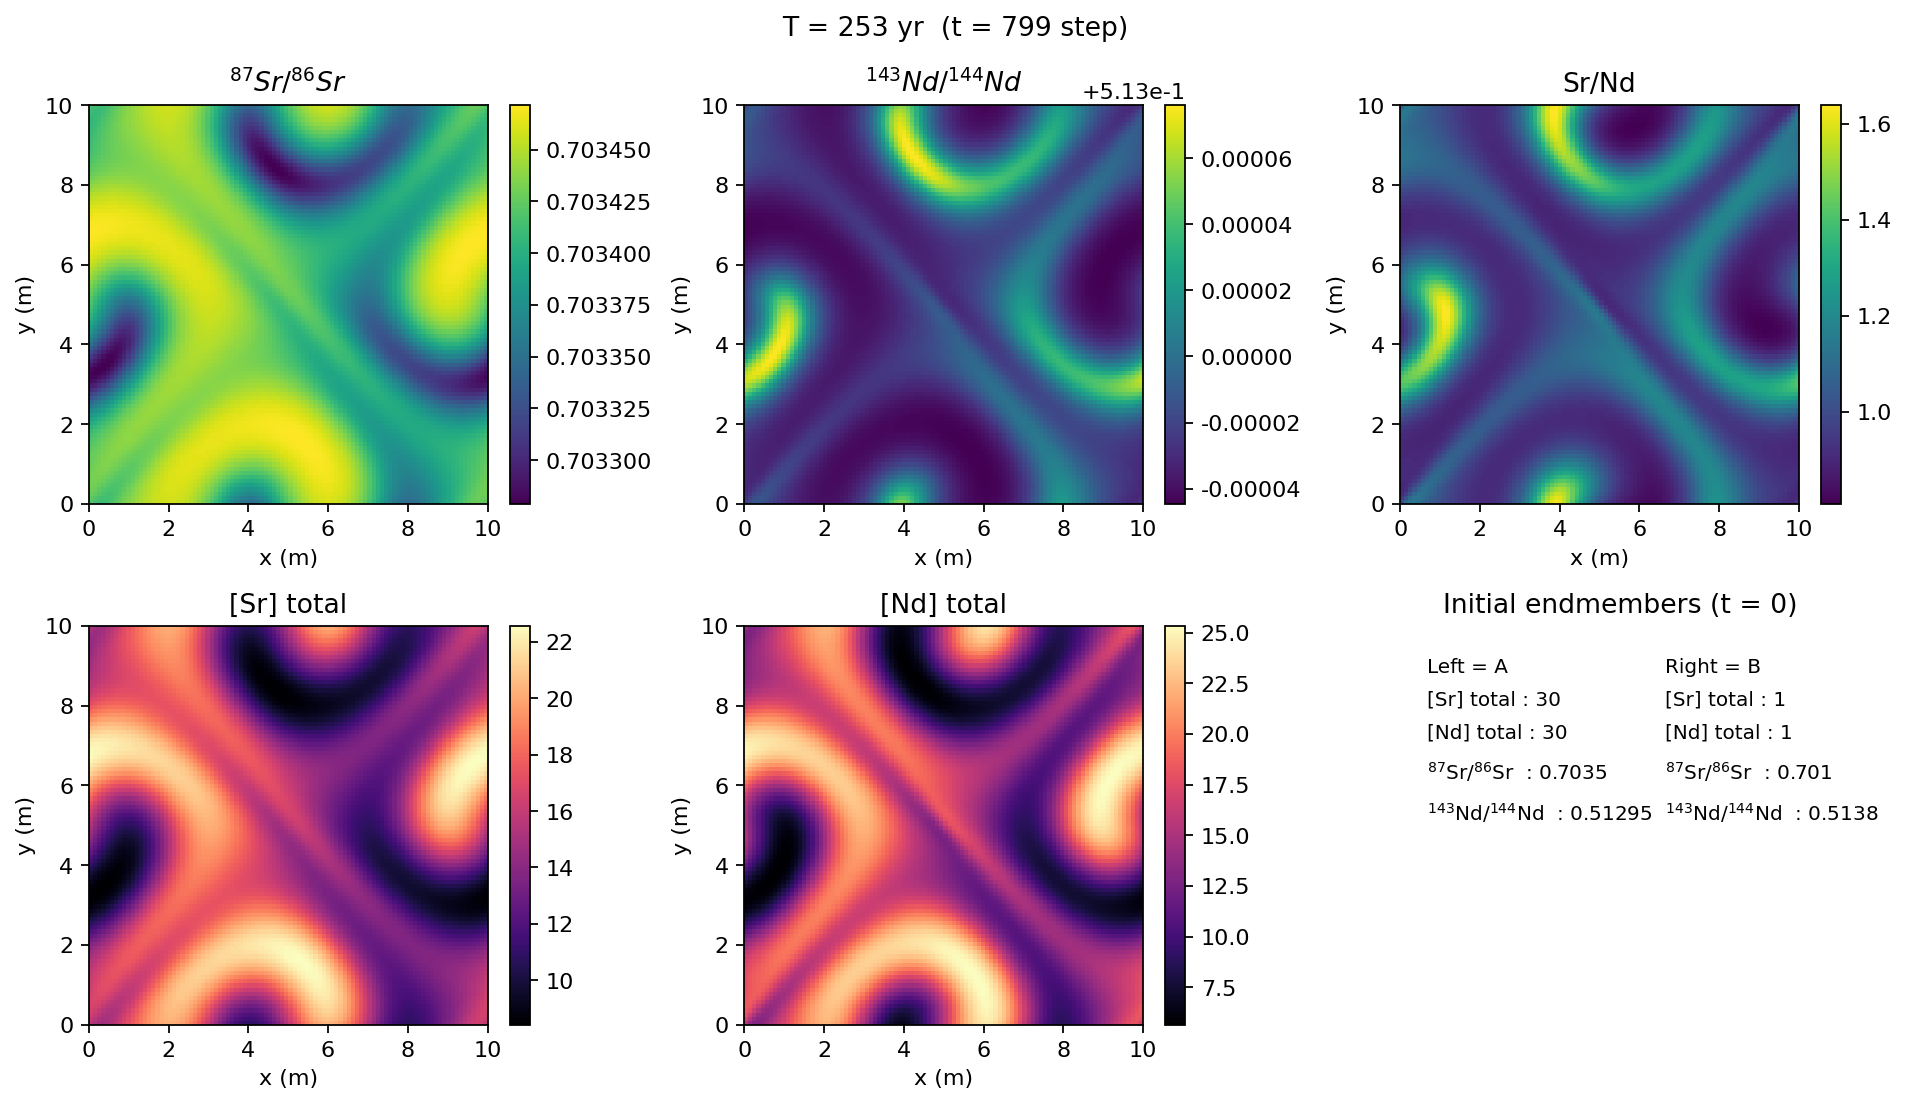

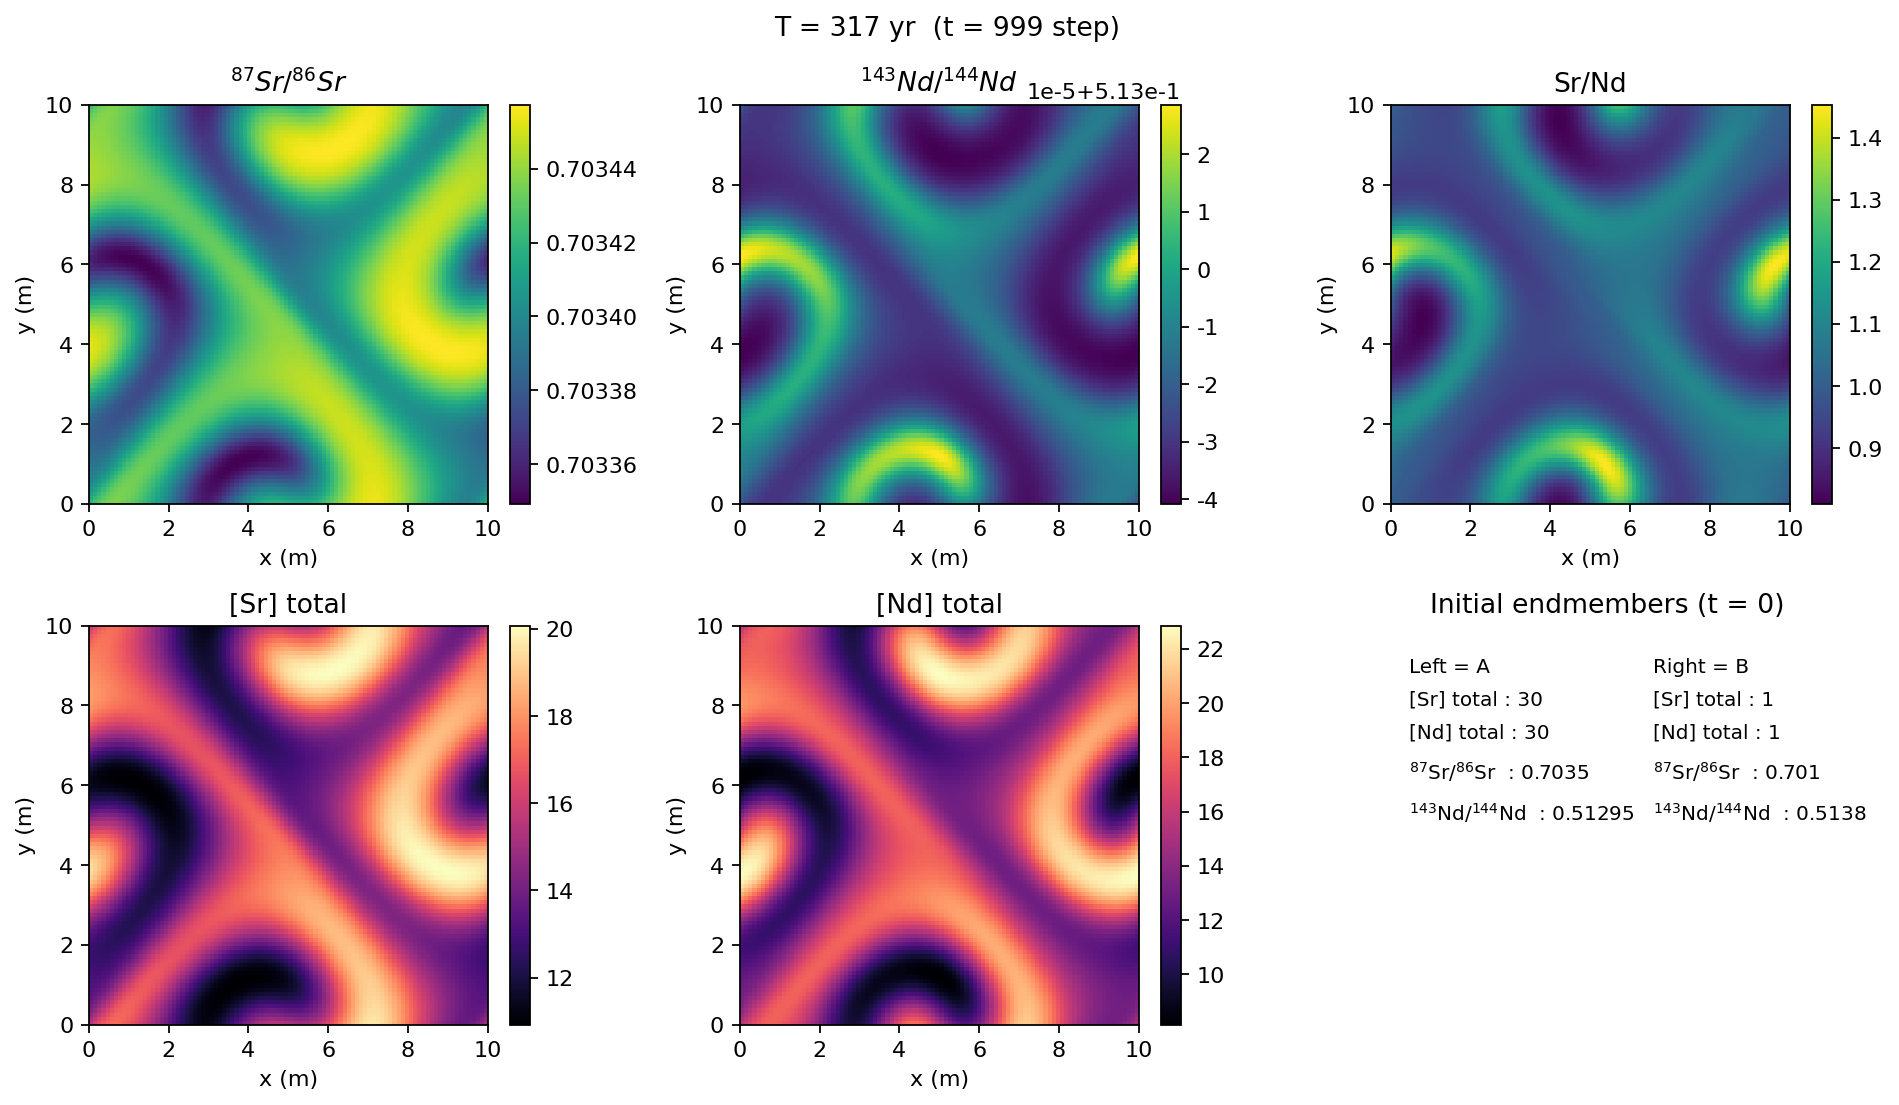

[Info] Loaded experimental data: iceland.xlsx / Sheet1, rows=80


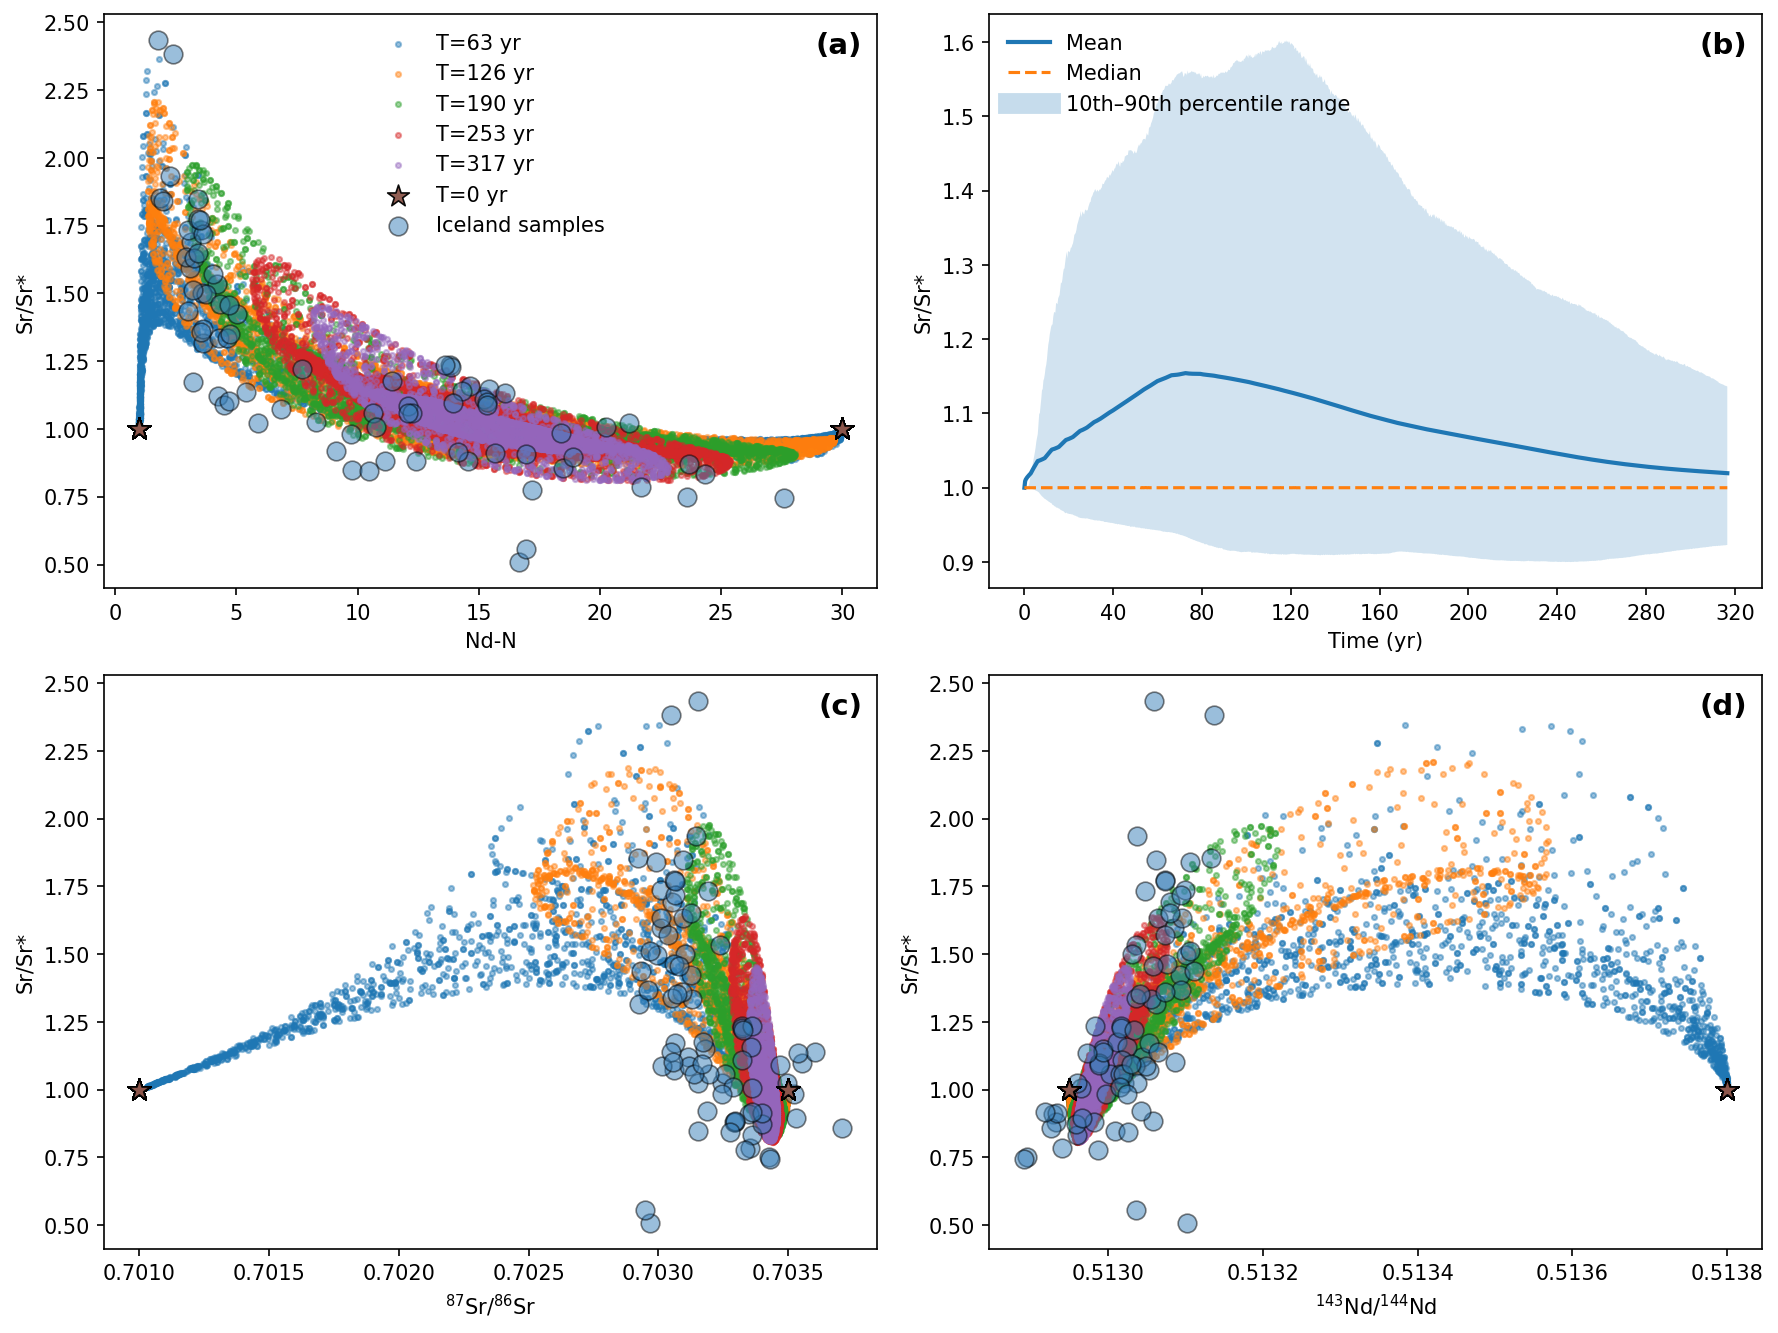

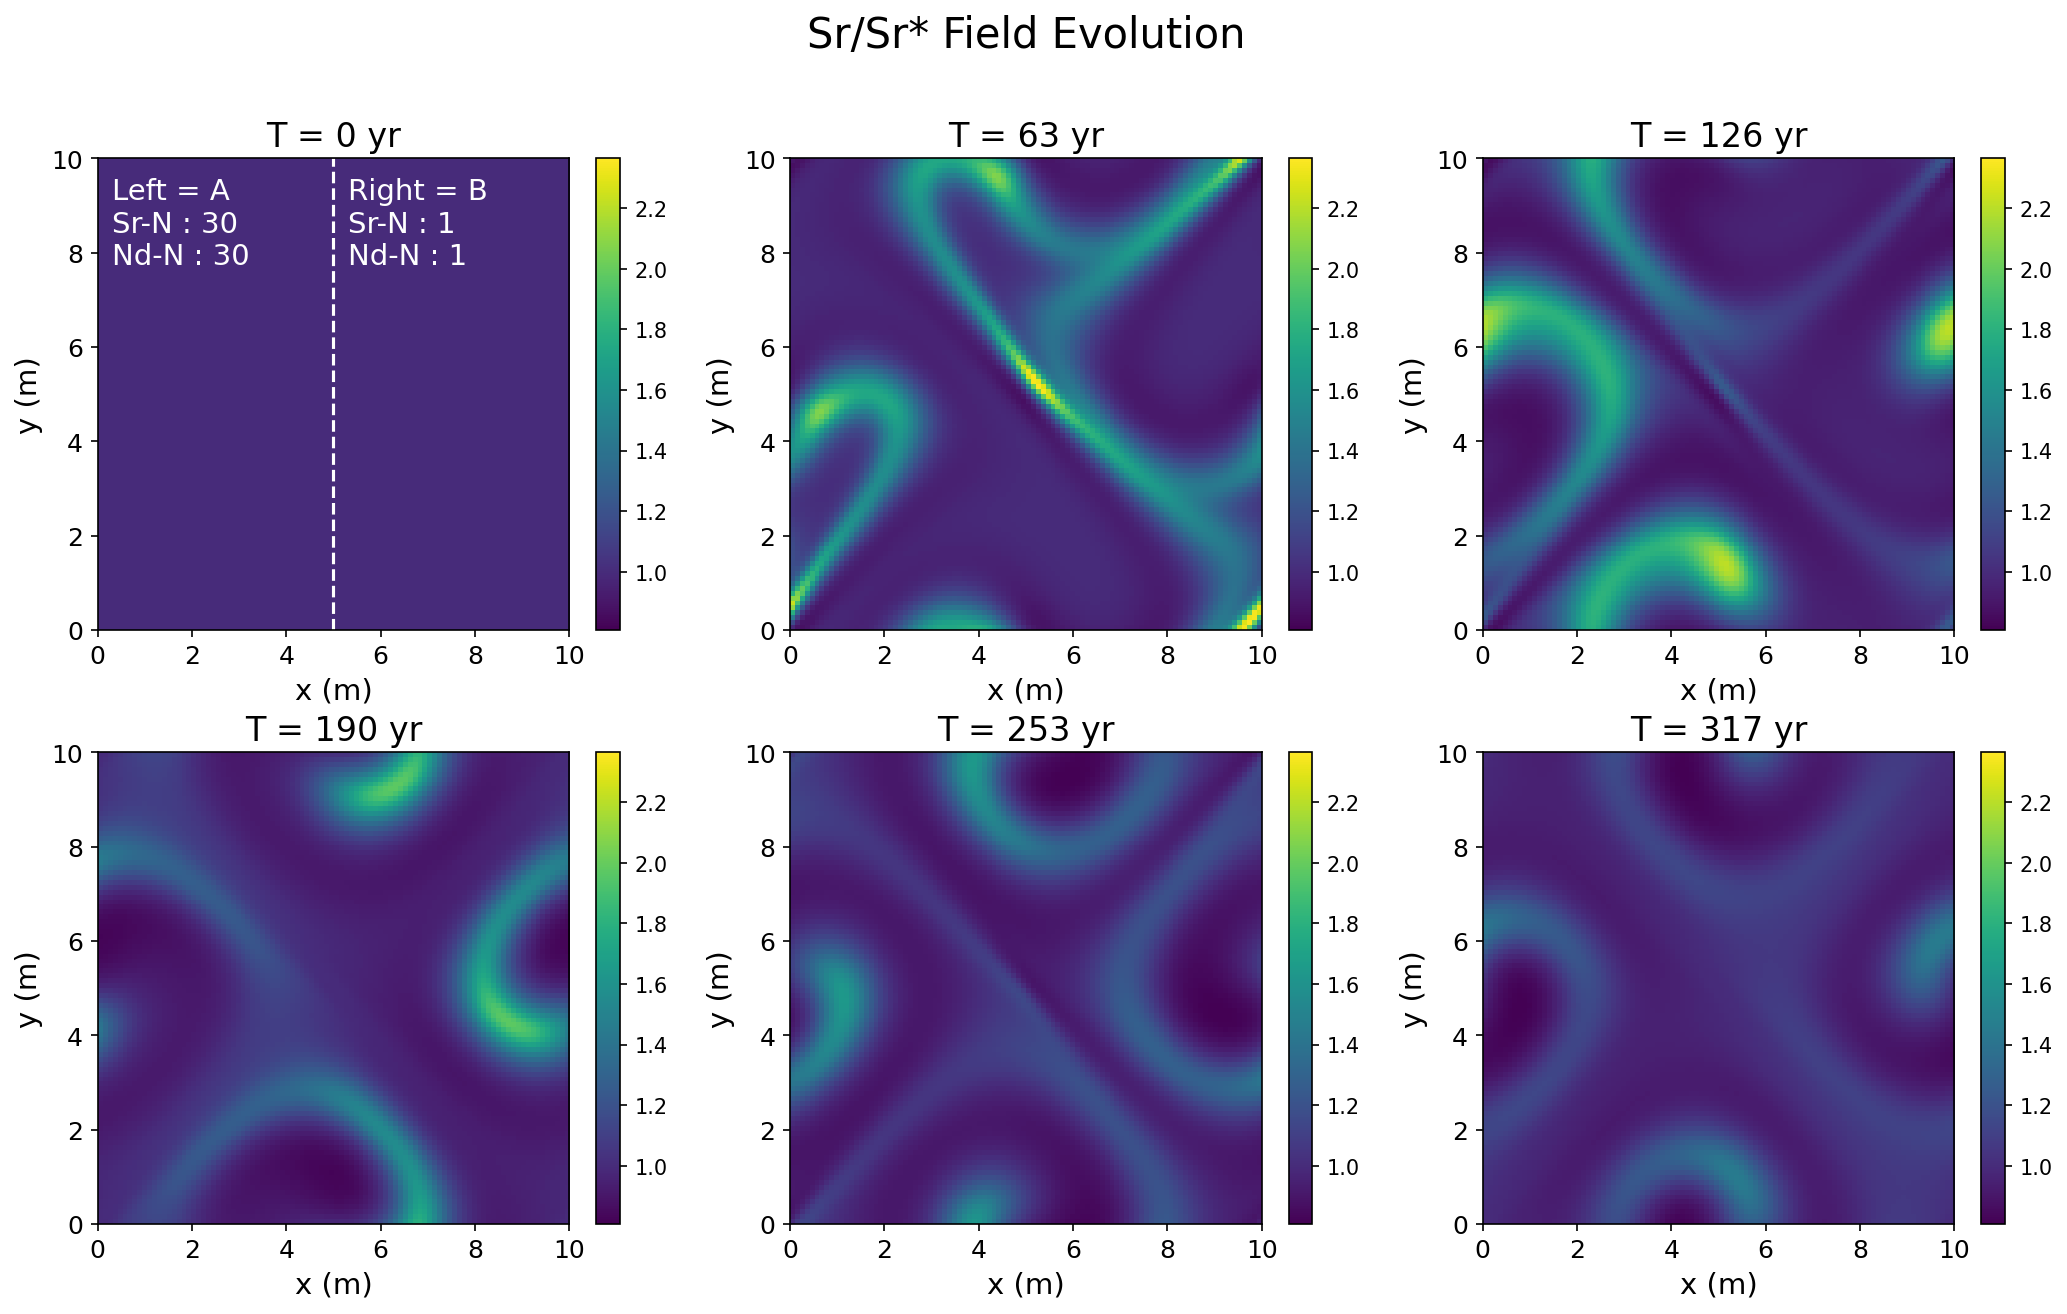

[Info] Saved 2×3 Sr/Nd annotated field map: SrNd_fields_2x3_annotated.png


In [ ]:
"""
2-D Advection–Diffusion Magma Mixing (Sr & Nd isotopes) — Constant-velocity version
----------------------------------------------------------------------------------
Key points of this version:
1) Endmembers contain only Sr and Nd total concentrations and isotope ratios; no viscosity field.
2) Velocity field is independent of viscosity; A0 is a constant amplitude.
3) No A0_cap velocity limiter (if cross-cell artifacts occur, reduce A0 or dt, or increase N).
"""

# ====================== 1. Import basic libraries ======================
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import MaxNLocator, FormatStrFormatter
from dataclasses import dataclass, asdict
import csv, os
import pandas as pd

# ===== Fix garbled characters (keep default font family): disable TeX, increase clarity =====
mpl.rcParams['text.usetex'] = False
mpl.rcParams['axes.unicode_minus'] = False
mpl.rcParams['figure.dpi'] = 120

# ====================== 2. (Optional) Function to read experimental Excel data ======================
def read_experiment_excel(path, sheet_name=0):
    """
    Read experimental data and normalize column names for later plotting.
    Recognized fields: Nd, Sr/Nd (or compute from Sr & Nd), 87Sr/86Sr, 143Nd/144Nd, Label (optional).
    """
    df = pd.read_excel(path, sheet_name=sheet_name)
    aliases = {
        "Nd": ["Nd", "[Nd]", "Nd_total"],
        "Sr_over_Nd": ["Sr/Nd", "Sr_over_Nd", "SrNd", "Sr_over_Nd_ratio"],
        "R_87Sr_86Sr": ["87Sr/86Sr", "R_87Sr_86Sr", "Sr_isotope"],
        "R_143Nd_144Nd": ["143Nd/144Nd", "R_143Nd_144Nd", "Nd_isotope"],
        "Sr": ["Sr", "[Sr]", "Sr_total"],
        "Label": ["Label", "Sample", "ID", "Name"]
    }
    def pick(cols):
        for c in cols:
            if c in df.columns:
                return c
        return None

    out = pd.DataFrame()
    c = pick(aliases["Nd"])
    if c is not None: out["Nd"] = df[c]

    c = pick(aliases["Sr_over_Nd"])
    if c is not None:
        out["Sr_over_Nd"] = df[c]
    else:
        c_sr, c_nd = pick(aliases["Sr"]), pick(aliases["Nd"])
        if c_sr is None or c_nd is None:
            raise ValueError("Missing Sr/Nd or (Sr and Nd) columns; cannot compute Sr/Nd.")
        out["Sr_over_Nd"] = df[c_sr] / df[c_nd]

    c = pick(aliases["R_87Sr_86Sr"])
    if c is not None: out["R_87Sr_86Sr"] = df[c]

    c = pick(aliases["R_143Nd_144Nd"])
    if c is not None: out["R_143Nd_144Nd"] = df[c]

    c = pick(aliases["Label"])
    if c is not None: out["Label"] = df[c].astype(str)

    return out.dropna(how="all")

# ====================== 3. Dataclass parameter structures ======================
@dataclass
class Endmember:
    """Endmember parameters: only chemical concentrations and isotope ratios."""
    Sr_total: float
    Nd_total: float
    R_87Sr_86Sr: float
    R_143Nd_144Nd: float

@dataclass
class SimConfig:
    """Global simulation configuration: A0 = constant velocity amplitude."""
    # Grid and time
    N: int = 96
    L: float = 10.0           # m
    dt: float = 1.0e7         # s  (~0.317 yr)
    steps: int = 1000         # Scatter plots use steps=1000

    # Sine-flow parameters (constant amplitude)
    A0: float = 4e-9          # m/s (recommended 1e-9–1e-8; too large -> cell crossing artifacts)
    switch_period: int = 10   # Switch flow direction every N steps (x <-> y)

    # Diffusion coefficients m2/s
    kappa_87Sr: float = 6e-11
    kappa_86Sr: float = 6e-11
    kappa_143Nd: float = 2e-11
    kappa_144Nd: float = 2e-11
    kappa_tracer: float = 6e-11

    # Output
    snapshot_count: int = 6
    save_npz: bool = True
    save_csv_timeseries: bool = True
    outdir: str = "mixing"

    # Time unit
    seconds_per_year: float = 365.25 * 86400.0
    time_unit_label: str = "yr"

# Endmembers (no viscosity fields)
A = Endmember(30, 30, 0.7035, 0.51295)   # Sr Nd, 87/86, 143/144
B = Endmember(1,  1,  0.701, 0.5138)
CFG = SimConfig()

def steps_to_years(steps):
    """Convert step number → years; used to show time in plots."""
    return np.asarray(steps, dtype=float) * CFG.dt / CFG.seconds_per_year

# ====================== 4. Grid and initial conditions ======================
N, L, dt = CFG.N, CFG.L, CFG.dt
dx = L / N; dy = L / N
x = (np.arange(N) + 0.5) * dx
y = (np.arange(N) + 0.5) * dy
X, Y = np.meshgrid(x, y, indexing="ij")

def split_field(valA, valB, frac=0.5):
    """Initialize left = A, right = B."""
    F = np.zeros((N, N))
    F[X < frac*L]  = valA
    F[X >= frac*L] = valB
    return F

def split_isotopes(total_A, total_B, R_A, R_B):
    """
    Split isotopic components according to total concentration and isotope ratio:
      heavy = R/(1+R)*total
      light = 1/(1+R)*total
    Then apply left-right initialization.
    """
    heavy = split_field(R_A/(1+R_A)*total_A, R_B/(1+R_B)*total_B)
    light = split_field(1/(1+R_A)*total_A,  1/(1+R_B)*total_B)
    return heavy, light

# Initialize fields
Sr87, Sr86   = split_isotopes(A.Sr_total,  B.Sr_total,  A.R_87Sr_86Sr,  B.R_87Sr_86Sr)
Nd143, Nd144 = split_isotopes(A.Nd_total,  B.Nd_total,  A.R_143Nd_144Nd, B.R_143Nd_144Nd)
F_A = split_field(1.0, 0.0)

# ====================== 5. Core numerics: Advection + Diffusion ======================
def semi_lagrangian_advect(C, u, v, dt_local):
    """Semi-Lagrangian advection (periodic boundaries + bilinear interpolation)."""
    Xb = (X - u * dt_local) % L
    Yb = (Y - v * dt_local) % L
    xb = Xb / dx - 0.5
    yb = Yb / dy - 0.5
    i0 = np.floor(xb).astype(int) % N; j0 = np.floor(yb).astype(int) % N
    i1 = (i0 + 1) % N;               j1 = (j0 + 1) % N
    sx = xb - np.floor(xb);          sy = yb - np.floor(yb)
    C00 = C[i0, j0]; C10 = C[i1, j0]; C01 = C[i0, j1]; C11 = C[i1, j1]
    return (1-sx)*(1-sy)*C00 + sx*(1-sy)*C10 + (1-sx)*sy*C01 + sx*sy*C11

def diffuse_fd(C, kappa, dt_local):
    """Explicit diffusion (periodic Laplacian)."""
    Cxx = (np.roll(C,-1,0)-2*C+np.roll(C,1,0))/dx**2
    Cyy = (np.roll(C,-1,1)-2*C+np.roll(C,1,1))/dy**2
    return C + kappa * dt_local * (Cxx + Cyy)

def element_totals():
    """Return Sr_tot, Nd_tot."""
    return Sr87 + Sr86, Nd143 + Nd144

def ratios():
    """Compute R_Sr, R_Nd, R_SrNd, Sr_tot, Nd_tot."""
    Sr_tot, Nd_tot = element_totals()
    R_Sr   = np.where(Sr86  > 0, Sr87/Sr86,      np.nan)
    R_Nd   = np.where(Nd144 > 0, Nd143/Nd144,    np.nan)
    R_SrNd = np.where(Nd_tot > 0, Sr_tot/Nd_tot, np.nan)
    return R_Sr, R_Nd, R_SrNd, Sr_tot, Nd_tot

# ====================== 6. Diffusion stability warning ======================
kappa_max = max(CFG.kappa_87Sr, CFG.kappa_86Sr, CFG.kappa_143Nd, CFG.kappa_144Nd, CFG.kappa_tracer)
dt_stable = min(dx, dy)**2 / (4*kappa_max + 1e-30)
if dt > dt_stable:
    print(f"[Warning] dt={dt} > dt_stable≈{dt_stable:.4g}; explicit diffusion may be unstable. Reduce dt or increase N.")

# ====================== 7. Time stepping (constant-amplitude sine flow) ======================
def take_snapshot(t, snaps_dict):
    """Save snapshots of: R_Sr, R_Nd, R_SrNd, Sr_tot, Nd_tot, F_A."""
    R_Sr, R_Nd, R_SrNd, Sr_tot, Nd_tot = ratios()
    snaps_dict[t] = dict(R_Sr=R_Sr.copy(), R_Nd=R_Nd.copy(),
                         R_SrNd=R_SrNd.copy(), Sr_tot=Sr_tot.copy(),
                         Nd_tot=Nd_tot.copy(), F_A=F_A.copy())

os.makedirs(CFG.outdir, exist_ok=True)
snap_ids = np.linspace(0, CFG.steps-1, CFG.snapshot_count, dtype=int)
snaps = {}
ts, mean_srnd, med_srnd, p10_srnd, p90_srnd = [], [], [], [], []

# t = 0: initial statistics and snapshot
if 0 in snap_ids:
    take_snapshot(0, snaps)
R0 = ratios()[2]; r0 = R0[np.isfinite(R0)]
ts.append(0); mean_srnd.append(float(np.mean(r0))); med_srnd.append(float(np.median(r0)))
p10_srnd.append(float(np.percentile(r0,10))); p90_srnd.append(float(np.percentile(r0,90)))

# —— Main loop (no A0 cap, no viscosity coupling) ——
for t in range(1, CFG.steps):
    amp = CFG.A0  # Constant amplitude

    # Alternating sine-flow directions (switch x/y every switch_period steps)
    phase = (t // CFG.switch_period) % 2
    if phase == 0:
        u = amp * np.sin(2*np.pi*(Y/L)); v = np.zeros_like(u)
    else:
        u = np.zeros_like(X);            v = amp * np.sin(2*np.pi*(X/L))

    # Semi-Lagrangian advection
    for C in (Sr87, Sr86, Nd143, Nd144, F_A):
        C[:] = semi_lagrangian_advect(C, u, v, dt)

    # Explicit diffusion
    Sr87[:] = diffuse_fd(Sr87, CFG.kappa_87Sr, dt)
    Sr86[:] = diffuse_fd(Sr86, CFG.kappa_86Sr, dt)
    Nd143[:] = diffuse_fd(Nd143, CFG.kappa_143Nd, dt)
    Nd144[:] = diffuse_fd(Nd144, CFG.kappa_144Nd, dt)
    F_A[:]   = diffuse_fd(F_A,   CFG.kappa_tracer, dt)

    # Save snapshots
    if t in snap_ids:
        take_snapshot(t, snaps)

    # Time-series statistics
    _, _, R_SrNd, _, _ = ratios()
    r = R_SrNd[np.isfinite(R_SrNd)]
    ts.append(t)
    mean_srnd.append(float(np.mean(r)))
    med_srnd.append(float(np.median(r)))
    p10_srnd.append(float(np.percentile(r, 10)))
    p90_srnd.append(float(np.percentile(r, 90)))

# ====================== 8. Save output ======================
if CFG.save_npz:
    np.savez(os.path.join(CFG.outdir, "snaps.npz"),
             snaps_times=np.array(sorted(snaps.keys())),
             **{f"{t}_R_Sr":snaps[t]["R_Sr"] for t in snaps},
             **{f"{t}_R_Nd":snaps[t]["R_Nd"] for t in snaps},
             **{f"{t}_R_SrNd":snaps[t]["R_SrNd"] for t in snaps},
             **{f"{t}_Sr_tot":snaps[t]["Sr_tot"] for t in snaps},
             **{f"{t}_Nd_tot":snaps[t]["Nd_tot"] for t in snaps},
             **{f"{t}_F_A":snaps[t]["F_A"] for t in snaps},
             config=np.bytes_(str(asdict(CFG))),
             A_params=np.bytes_(str(asdict(A))),
             B_params=np.bytes_(str(asdict(B))))

if CFG.save_csv_timeseries:
    with open(os.path.join(CFG.outdir, "Sr_over_Nd_timeseries.csv"), "w", newline="") as f:
        w = csv.writer(f)
        w.writerow(["step","mean_Sr/Nd","median_Sr/Nd","P10","P90"])
        for row in zip(ts, mean_srnd, med_srnd, p10_srnd, p90_srnd):
            w.writerow(row)

# ====================== 9. Plotting functions ======================
def plot_maps_at_time(t, data):
    """Six-panel map + initial endmember info in lower-right; title shows integer years."""
    R_Sr, R_Nd, R_SrNd = data["R_Sr"], data["R_Nd"], data["R_SrNd"]
    Sr_tot, Nd_tot     = data["Sr_tot"], data["Nd_tot"]
    fig, axs = plt.subplots(2, 3, figsize=(12, 7), dpi=160)
    ims = []; extent = [0, L, 0, L]

    ims.append(axs[0,0].imshow(R_Sr.T,   origin="lower", cmap="viridis", extent=extent)); axs[0,0].set_title(r"$^{87}Sr/^{86}Sr$")
    ims.append(axs[0,1].imshow(R_Nd.T,   origin="lower", cmap="viridis", extent=extent)); axs[0,1].set_title(r"$^{143}Nd/^{144}Nd$")
    ims.append(axs[0,2].imshow(R_SrNd.T, origin="lower", cmap="viridis", extent=extent)); axs[0,2].set_title("Sr/Nd")

    ims.append(axs[1,0].imshow(Sr_tot.T, origin="lower", cmap="magma", extent=extent)); axs[1,0].set_title("[Sr] total")
    ims.append(axs[1,1].imshow(Nd_tot.T, origin="lower", cmap="magma", extent=extent)); axs[1,1].set_title("[Nd] total")

    # Right-lower information panel (no viscosity)
    ax_info = axs[1,2]; ax_info.axis("off"); ax_info.set_title("Initial endmembers (t = 0)")
    iso_sr = r"$^{87}\mathrm{Sr}/^{86}\mathrm{Sr}$"; iso_nd = r"$^{143}\mathrm{Nd}/^{144}\mathrm{Nd}$"
    left_text = "\n".join([
        "Left = A",
        f"[Sr] total : {A.Sr_total:.6g}",
        f"[Nd] total : {A.Nd_total:.6g}",
        f"{iso_sr}  : {A.R_87Sr_86Sr:.6g}",
        f"{iso_nd}  : {A.R_143Nd_144Nd:.6g}",
    ])
    right_text = "\n".join([
        "Right = B",
        f"[Sr] total : {B.Sr_total:.6g}",
        f"[Nd] total : {B.Nd_total:.6g}",
        f"{iso_sr}  : {B.R_87Sr_86Sr:.6g}",
        f"{iso_nd}  : {B.R_143Nd_144Nd:.6g}",
    ])
    ax_info.text(0.06, 0.92, left_text,  transform=ax_info.transAxes, ha='left', va='top', fontsize=9, linespacing=1.9)
    ax_info.text(0.60, 0.92, right_text, transform=ax_info.transAxes, ha='left', va='top', fontsize=9, linespacing=1.9)

    for ax in axs.ravel()[:5]:
        ax.set_xlim(0, L); ax.set_ylim(0, L)
        ax.set_xlabel("x (m)"); ax.set_ylabel("y (m)")
    for im, ax in zip(ims, axs.ravel()[:5]):
        plt.colorbar(im, ax=ax, fraction=0.046)

    Ty = steps_to_years(t)
    fig.suptitle(f"T = {Ty:.0f} {CFG.time_unit_label}  (t = {t} step)")
    plt.tight_layout()
    plt.savefig(os.path.join(CFG.outdir, f"maps_t{t}.png"), dpi=160)
    plt.show()


def plot_combined_srnd_2x2(
    snaps, times_to_plot,
    ts, mean_srnd, med_srnd, p10_srnd, p90_srnd,
    exp_df=None,
    exp_label="Experimental data",
    exp_size=60, exp_marker='D', exp_color='#d62728',
    exp_edgecolor='k', exp_alpha=0.9):

    """
    2×2 multi-panel figure:
      (0,0) Nd vs Sr/Nd
      (0,1) Sr/Nd time series
      (1,0) Sr/Nd vs 87Sr/86Sr
      (1,1) Sr/Nd vs 143Nd/144Nd

    Enhancement: use large star marker for T=0, rendered on top.
    """

    fig, axs = plt.subplots(2, 2, figsize=(12, 9), dpi=150)

    # Add panel labels (a)-(d)
    panel_labels = ['(a)', '(b)', '(c)', '(d)']
    for label, ax in zip(panel_labels, axs.ravel()):
        ax.text(0.98, 0.97, label, transform=ax.transAxes,
            fontsize=14, fontweight='bold',
            ha='right', va='top')

    # Sorting: non-zero times first, T=0 last to ensure overlay order
    tp = list(times_to_plot)
    t0_present = (0 in tp)
    others = [t for t in tp if t != 0]
    ordered_times = others + ([0] if t0_present else [])

    # Style for T=0
    T0_STYLE = dict(s=120, marker='*', linewidths=0.8,
                    edgecolors='k', alpha=0.95, zorder=6)

    # Style for other times
    OTHER_STYLE = dict(s=6, alpha=0.45, zorder=3)

    # =======================================
    # (0,0) Nd vs Sr/Nd
    # =======================================
    ax = axs[0,0]

    for t in others:
        Nd   = snaps[t]["Nd_tot"].ravel()
        SrNd = (snaps[t]["Sr_tot"] / snaps[t]["Nd_tot"]).ravel()
        idx  = np.random.choice(Nd.size, size=min(4000, Nd.size), replace=False)
        Ty   = steps_to_years(t)
        ax.scatter(Nd[idx], SrNd[idx],
                   label=f"T={Ty:.0f} {CFG.time_unit_label}",
                   **OTHER_STYLE)

    if t0_present:
        t = 0
        Nd   = snaps[t]["Nd_tot"].ravel()
        SrNd = (snaps[t]["Sr_tot"] / snaps[t]["Nd_tot"]).ravel()
        idx  = np.random.choice(Nd.size, size=min(4000, Nd.size), replace=False)
        Ty   = steps_to_years(t)
        ax.scatter(Nd[idx], SrNd[idx],
                   label=f"T={Ty:.0f} {CFG.time_unit_label}",
                   **T0_STYLE)

    if exp_df is not None and {"Nd","Sr_over_Nd"}.issubset(exp_df.columns):
        ax.scatter(exp_df["Nd"], exp_df["Sr_over_Nd"],
                   s=exp_size, marker=exp_marker, c=exp_color,
                   edgecolors=exp_edgecolor, linewidths=0.8, alpha=exp_alpha,
                   label=exp_label, zorder=4)

    ax.set_xlabel("Nd-N");
    ax.set_ylabel("Sr/Sr*")
    ax.grid(False)
    ax.legend(loc='upper center',
              bbox_to_anchor=(0.5, 1),
              ncol=1, frameon=False)

    # =======================================
    # (0,1) Sr/Nd time series
    # =======================================
    ax = axs[0,1]
    t_years = steps_to_years(ts)
    line_mean,   = ax.plot(t_years, mean_srnd, linewidth=2, label="Mean")
    line_median, = ax.plot(t_years, med_srnd, linestyle="--", label="Median")
    band = ax.fill_between(t_years, p10_srnd, p90_srnd, alpha=0.2)
    band_color = band.get_facecolor()[0]

    from matplotlib.lines import Line2D
    band_handle = Line2D([0], [0], lw=10, alpha=0.25,
                         color=band_color, label="10th–90th percentile range")

    ax.set_xlabel(f"Time ({CFG.time_unit_label})")
    ax.set_ylabel("Sr/Sr*")
    ax.grid(False)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    ax.legend(handles=[line_mean, line_median, band_handle],
              frameon=False, loc="upper left")

    # =======================================
    # (1,0) Sr/Nd vs 87Sr/86Sr
    # =======================================
    ax = axs[1,0]
    for t in others:
        R_Sr   = snaps[t]["R_Sr"].ravel()
        SrNd   = snaps[t]["R_SrNd"].ravel()
        m = np.isfinite(R_Sr) & np.isfinite(SrNd)
        if m.any():
            idx = np.random.choice(np.where(m)[0],
                                   size=min(4000, m.sum()),
                                   replace=False)
            Ty = steps_to_years(t)
            ax.scatter(R_Sr[idx], SrNd[idx],
                       label=f"T={Ty:.0f} {CFG.time_unit_label}",
                       **OTHER_STYLE)

    if t0_present:
        t = 0
        R_Sr   = snaps[t]["R_Sr"].ravel()
        SrNd   = snaps[t]["R_SrNd"].ravel()
        m = np.isfinite(R_Sr) & np.isfinite(SrNd)
        if m.any():
            idx = np.random.choice(np.where(m)[0],
                                   size=min(4000, m.sum()),
                                   replace=False)
            Ty = steps_to_years(t)
            ax.scatter(R_Sr[idx], SrNd[idx],
                       label=f"T={Ty:.0f} {CFG.time_unit_label}",
                       **T0_STYLE)

    if exp_df is not None and {"Sr_over_Nd","R_87Sr_86Sr"}.issubset(exp_df.columns):
        ax.scatter(exp_df["R_87Sr_86Sr"], exp_df["Sr_over_Nd"],
                   s=exp_size, marker=exp_marker, c=exp_color,
                   edgecolors=exp_edgecolor, linewidths=0.8, alpha=exp_alpha,
                   label=exp_label, zorder=4)

    ax.set_xlabel(r"$^{87}\mathrm{Sr}/^{86}\mathrm{Sr}$")
    ax.set_ylabel("Sr/Sr*")
    ax.grid(False)
    ax.legend(frameon=False)
    if ax.get_legend(): ax.get_legend().remove()

    # =======================================
    # (1,1) Sr/Nd vs 143Nd/144Nd
    # =======================================
    ax = axs[1,1]
    for t in others:
        R_Nd   = snaps[t]["R_Nd"].ravel()
        SrNd   = snaps[t]["R_SrNd"].ravel()
        m = np.isfinite(R_Nd) & np.isfinite(SrNd)
        if m.any():
            idx = np.random.choice(np.where(m)[0],
                                   size=min(4000, m.sum()),
                                   replace=False)
            Ty = steps_to_years(t)
            ax.scatter(R_Nd[idx], SrNd[idx],
                       label=f"T={Ty:.0f} {CFG.time_unit_label}",
                       **OTHER_STYLE)

    if t0_present:
        t = 0
        R_Nd   = snaps[t]["R_Nd"].ravel()
        SrNd   = snaps[t]["R_SrNd"].ravel()
        m = np.isfinite(R_Nd) & np.isfinite(SrNd)
        if m.any():
            idx = np.random.choice(np.where(m)[0],
                                   size=min(4000, m.sum()),
                                   replace=False)
            Ty = steps_to_years(t)
            ax.scatter(R_Nd[idx], SrNd[idx],
                       label=f"T={Ty:.0f} {CFG.time_unit_label}",
                       **T0_STYLE)

    if exp_df is not None and {"Sr_over_Nd","R_143Nd_144Nd"}.issubset(exp_df.columns):
        ax.scatter(exp_df["R_143Nd_144Nd"], exp_df["Sr_over_Nd"],
                   s=exp_size, marker=exp_marker, c=exp_color,
                   edgecolors=exp_edgecolor, linewidths=0.8,
                   alpha=exp_alpha, label=exp_label, zorder=4)

    ax.set_xlabel(r"$^{143}\mathrm{Nd}/^{144}\mathrm{Nd}$")
    ax.set_ylabel("Sr/Sr*")
    ax.grid(False)
    ax.legend(frameon=False, loc="upper left")
    if ax.get_legend(): ax.get_legend().remove()

    plt.tight_layout()
    plt.savefig(os.path.join(CFG.outdir, "Combined_SrNd_2x2.png"), dpi=160)
    plt.show()

# ====================== 12. New: 2×3 Sr/Nd field maps ======================
def plot_srnd_fields_2x3_with_annotation(snaps, steps, outname="SrNd_fields_2x3_annotated.png"):
    """
    Plot 6 Sr/Nd field snapshots in a 2×3 layout.
    Annotation and division line added to the t=0 panel.
    Automatic times: 0, 1/5, 2/5, 3/5, 4/5, final.
    """
    # Select 6 time steps from 0 → steps-1
    times_to_plot = np.linspace(0, steps - 1, 6, dtype=int)
    times_to_plot = [t for t in times_to_plot if t in snaps]

    # Unified colormap range (exclude NaN)
    all_vals = []
    for t in times_to_plot:
        SrNd = snaps[t]["R_SrNd"]
        all_vals.append(SrNd[np.isfinite(SrNd)])
    vmin = min([v.min() for v in all_vals])
    vmax = max([v.max() for v in all_vals])

    # Plot 2×3 figure
    fig, axs = plt.subplots(2, 3, figsize=(14, 8.5), dpi=150)
    extent = [0, CFG.L, 0, CFG.L]

    for ax, t in zip(axs.ravel(), times_to_plot):
        SrNd = snaps[t]["R_SrNd"].T
        im = ax.imshow(SrNd, origin="lower", extent=extent,
                       cmap="viridis", vmin=vmin, vmax=vmax)
        Ty = steps_to_years(t)
        ax.set_title(f"T = {Ty:.0f} {CFG.time_unit_label}", fontsize=16)
        ax.set_xlabel("x (m)", fontsize=14)
        ax.set_ylabel("y (m)", fontsize=14)
        ax.tick_params(axis='both', labelsize=12)
        plt.colorbar(im, ax=ax, fraction=0.046)

        # Extra annotation for t = 0
        if t == 0:
            ax.axvline(CFG.L / 2, color='white', linestyle='--', linewidth=1.5)

            left_text = "\n".join([
                "Left = A",
                f"Sr-N : {A.Sr_total:.6g}",
                f"Nd-N : {A.Nd_total:.6g}"
            ])
            right_text = "\n".join([
                "Right = B",
                f"Sr-N : {B.Sr_total:.6g}",
                f"Nd-N : {B.Nd_total:.6g}"
            ])
            ax.text(0.3, CFG.L - 0.4, left_text,
                    ha='left', va='top', fontsize=14, color='white')
            ax.text(CFG.L/2 + 0.3, CFG.L - 0.4, right_text,
                    ha='left', va='top', fontsize=14, color='white')

    fig.suptitle("Sr/Sr* Field Evolution", fontsize=20, y=1.02)
    plt.tight_layout()
    plt.savefig(os.path.join(CFG.outdir, outname), dpi=160)
    plt.show()
    print(f"[Info] Saved 2×3 Sr/Nd annotated field map: {outname}")

# ====================== 10. Output and experimental-data overlay ======================
print(f"[Info] Output directory: {os.path.abspath(CFG.outdir)}")
print(f"[Info] dx={dx:.6g} m, dt={dt:.6g} s ≈ {dt/CFG.seconds_per_year:.3f} {CFG.time_unit_label}; A0={CFG.A0:.3e} m/s")

for t in snap_ids:
    plot_maps_at_time(t, snaps[t])

# Optional: load experimental Excel
EXP_PATH = "iceland.xlsx"
EXP_SHEET = "Sheet1"
exp_df = None
try:
    if os.path.exists(EXP_PATH):
        exp_df = read_experiment_excel(EXP_PATH, sheet_name=EXP_SHEET)
        print(f"[Info] Loaded experimental data: {EXP_PATH} / {EXP_SHEET}, rows={len(exp_df)}")
    else:
        print(f"[Note] Experimental Excel not found: {EXP_PATH} (simulation only)")
except Exception as e:
    print(f"[Warning] Failed to parse experimental Excel: {e} (simulation only)")

plot_combined_srnd_2x2(
    snaps, snap_ids,
    ts, mean_srnd, med_srnd, p10_srnd, p90_srnd,
    exp_df=exp_df,
    exp_label="Iceland samples",
    exp_size=80, exp_marker='o', exp_color='#377eb8',
    exp_edgecolor='k', exp_alpha=0.5
)

plot_srnd_fields_2x3_with_annotation(snaps, CFG.steps)
